In [2]:
import os
import typing
from dask_jobqueue import PBSCluster
from pathlib import Path

# Define the working directory path
working_directory = str(Path.cwd())

# Launch a scheduler and workers on HPC via PBS
cluster = PBSCluster(
     cores=4,
     memory="8GB",
     processes=1,
     queue="tamirQ",
     walltime="02:30:00",
     scheduler_options={"dashboard_address": ":12435"},  # FIXME - this is the port we need to define...
     # Additional custom options
     log_directory="dask-logs",
     #worker_extra_args=["--lifetime", "25m", "--lifetime-stagger", "4m"],  # for walltime="00:30:00"
     job_script_prologue=[f"cd {working_directory}"]
)
cluster
cluster.adapt(minimum=10, maximum=60)
print(cluster.job_script())
from dask.distributed import Client, progress, wait, get_client, get_worker
client = Client(cluster)
client

/tamir2/moranb/microbiome/Igem_TAU_2021/venv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 12435 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35660 instead
  warnings.warn(


#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q tamirQ
#PBS -l select=1:ncpus=4:mem=7630MB
#PBS -l walltime=02:30:00
#PBS -e dask-logs/
#PBS -o dask-logs/
cd /tamir2/moranb/microbiome/Igem_TAU_2021
/tamir2/moranb/microbiome/Igem_TAU_2021/venv/bin/python -m distributed.cli.dask_worker tcp://132.66.112.146:38436 --nthreads 4 --memory-limit 7.45GiB --name dummy-name --nanny --death-timeout 60



Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://132.66.112.146:35660/status,
Dashboard: http://132.66.112.146:35660/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://132.66.112.146:38436,Workers: 0
Dashboard: http://132.66.112.146:35660/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
import dask.bag as db
import dask.dataframe as dd
from dask import delayed, compute, persist
from pandas.core.dtypes.common import pandas_dtype as dtype
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import seaborn as sns
import operator
from Bio import SeqIO
from analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data
from analysis.input_testing_data.generate_input_testing_data_for_modules import generate_testing_data_for_ecoli_and_bacillus

from modules.main import run_modules
from modules.user_IO.input_functions import extract_gene_data

In [4]:
output_path = "/tamir2/moranb/microbiome/Igem_TAU_2021/analysis/results/homo_sapiens"
optimization_cub_index = "CAI"

variant_names = [
    "single_diff",
    "zscore_single_diff",
    "zscore_bulk_diff",
    "single_ratio",
    "zscore_single_ratio",
    "zscore_bulk_ratio",
    "single_wanted_organism",
]
variant_scores_names = ["{score}_" + variant_name for variant_name in variant_names]

average_distance_score_variant_names = [s.format(score="average_distance_score") for s in variant_scores_names]
ratio_score_variant_names = [s.format(score="ratio_score") for s in variant_scores_names]

In [5]:
def get_configuration(is_ecoli_optimized):
    return f"e_coli_optimized_{is_ecoli_optimized}_bacillus_optimized_{not is_ecoli_optimized}"
    
def get_orf_summary(summary: typing.Dict[str, typing.Any], evaluation_method: str = "average_distance_score") -> typing.Dict[str, typing.Any]:
    if len(summary["evaluation"]) == 1:
        return summary["orf"]
    final_evaluation = summary["final_evaluation"]
    for i, evaluation_summary in enumerate(summary["evaluation"]):
        if evaluation_summary[evaluation_method] == final_evaluation[evaluation_method]:
            return summary["orf"][i]

def get_total_run_time(summary: typing.Dict[str, typing.Any]) -> float:
     if len(summary["evaluation"]) == 1:
        return summary["orf"]["run_time"]
     run_time = 0
     for orf_summary in summary["orf"]:
         run_time += orf_summary["run_time"]
     return run_time
    
def convert_json(x):
    gene_name = x["gene_name"]
    result = x["summary"]
    orf = get_orf_summary(result)
    if "orf" not in result or orf is None: # probably thrown in case of an error
        return {"error": result, "gene_name": gene_name}
    run_time = get_total_run_time(result)
    iterations_count = str(orf.get("iterations_count", 1))
    return {
        "initial_optimization_score": orf.get("initial_sequence_optimization_score"),
        "final_optimization_score": orf.get("final_sequence_optimization_score"),
        "average_distance_score": result["final_evaluation"].get("average_distance_score"),
        "average_distance_non_normalized_score": result["final_evaluation"].get("average_distance_non_normalized_score"),
        "weakest_link_score": result["final_evaluation"].get("weakest_link_score"),
        "ratio_score": result["final_evaluation"].get("ratio_score"),
        "gene_name": gene_name,
        "orf_optimization_cub_index": result["module_input"].get("orf_optimization_cub_index"),
        "evaluation_score": result["module_input"].get("evaluation_score"),
        "run_time": run_time,
        "iterations_count": iterations_count,
        "final_sequence": result["final_evaluation"].get("final_sequence"),
    }

def json_map(x):
    x = x.strip("\n")
    result = None
    try:
        result = json.loads(x)
        return convert_json(result)
    except Exception as e:
        return {"error_message": "bad json string", "input": x}

In [6]:
def get_df_for_run_configuration(configuration, optimization_method, is_debug=False):
    configuration_output_path = os.path.join(output_path, configuration)
    debug_suffix = '-debug' if is_debug else ''
    results_dir = F"{os.path.join(configuration_output_path, optimization_method + debug_suffix)}"
    print(f"results dir is: {results_dir}")
    file_names = [str(file) for file in list(Path(results_dir).rglob("*.json"))]
    # bag = db.read_text(file_names).map(json.loads)
    bag = db.read_text(file_names).map(json_map)

    error_records = bag.filter(lambda x: "error_message" in x.keys())
    valid_records = bag.filter(lambda x: "error_message" not in x.keys())
    return valid_records.to_dataframe().compute(), error_records.compute()

    # return dd.read_json([str(file) for file in list(Path(results_dir).rglob("*.json"))], orient='records', lines=True)
    
def get_scores_df_by_configuration_df(configuration, is_debug=False):
    df_bulk_zscore_ratio, df_bulk_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_ratio", is_debug)
    df_bulk_zscore_diff, df_bulk_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_diff", is_debug)
    merged_bulk_zscore_df = dd.merge(df_bulk_zscore_ratio, df_bulk_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_bulk_ratio', '_zscore_bulk_diff'))

    df_single_zscore_ratio, df_single_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_ratio", is_debug)
    df_single_zscore_diff, df_single_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_single_aa_diff", is_debug)
    merged_single_zscore_df = dd.merge(df_single_zscore_ratio, df_single_zscore_diff, on='gene_name', how='inner', suffixes=('_zscore_single_ratio', '_zscore_single_diff'))

    df_single_codon_ratio, df_single_codon_ratio_error = get_df_for_run_configuration(configuration, "single_codon_ratio", is_debug)
    df_single_codon_diff, df_single_codon_diff_error = get_df_for_run_configuration(configuration, "single_codon_diff", is_debug)
    merged_single_df = dd.merge(df_single_codon_ratio, df_single_codon_diff, on='gene_name', how='inner', suffixes=('_single_ratio', '_single_diff'))
    
    merged_df = dd.merge(merged_bulk_zscore_df, merged_single_zscore_df, on='gene_name', how='inner')
    merged_df = dd.merge(merged_df, merged_single_df, on='gene_name', how='inner')
    
    df_single_wanted_organism, df_single_wanted_organism_error = get_df_for_run_configuration(configuration, "single_wanted_organism", is_debug)
    merged_df = dd.merge(merged_df, df_single_wanted_organism, on='gene_name', how='inner')

    merged_df = merged_df.rename(columns={
        'initial_optimization_score': 'initial_optimization_score_single_wanted_organism',
        'final_optimization_score': 'final_optimization_score_single_wanted_organism',
        'average_distance_score': 'average_distance_score_single_wanted_organism',
        'average_distance_non_normalized_score': 'average_distance_non_normalized_score_single_wanted_organism',
        'weakest_link_score': 'weakest_link_score_single_wanted_organism',
        'ratio_score': 'ratio_score_single_wanted_organism',
        'orf_optimization_cub_index': 'orf_optimization_cub_index_single_wanted_organism',
        'evaluation_score': 'evaluation_score_single_wanted_organism',
        'run_time': 'run_time_single_wanted_organism',
        'iterations_count': 'iterations_count_single_wanted_organism',
        'final_sequence': 'final_sequence_single_wanted_organism',
    })
    
    return merged_df, [
        df_bulk_zscore_ratio_errors,
        df_bulk_zscore_diff_errors, 
        df_single_zscore_ratio_errors, 
        df_single_zscore_diff_errors, 
        df_single_codon_ratio_error,
        df_single_codon_diff_error,
        df_single_wanted_organism_error,
    ]

In [7]:
def get_scores_df_by_configuration(configuration, is_debug=False):
    df_bulk_zscore_ratio, df_bulk_zscore_ratio_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_ratio", is_debug)
    df_bulk_zscore_diff, df_bulk_zscore_diff_errors = get_df_for_run_configuration(configuration, "zscore_bulk_aa_diff", is_debug)

    df_single_codon_ratio, df_single_codon_ratio_error = get_df_for_run_configuration(configuration, "single_codon_ratio", is_debug)
    df_single_codon_diff, df_single_codon_diff_error = get_df_for_run_configuration(configuration, "single_codon_diff", is_debug)

    return [
        df_bulk_zscore_ratio,
        df_bulk_zscore_diff,
        df_single_codon_ratio,
        df_single_codon_diff,
    ], [
        df_bulk_zscore_ratio_errors,
        df_bulk_zscore_diff_errors, 
        df_single_zscore_ratio_errors, 
        df_single_zscore_diff_errors, 
        df_single_codon_ratio_error,
        df_single_codon_diff_error,
    ]
    
def add_median_to_histogram(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-1, upper_limit, f"median={median_value}")
    
def add_median_to_histogram_non_normalized(value, histogram, row, col, upper_limit):
    median_value = value.median()
    histogram[row][col].axvline(median_value, color="green", linestyle="dashed", label="median")
    histogram[row][col].text(median_value-0.1, upper_limit, f"median={median_value}")

In [8]:
def plot_comparative_graphs(result, score_type):
    variant_scores = [s.format(score=score_type) for s in variant_scores_names]
    sns.set(style="whitegrid", context="paper")

    figure, axis = plt.subplots(7, 3, figsize=(25,40))

    index = 0
    for i, first_variant in enumerate(variant_scores):
        for j, second_variant in enumerate(variant_scores):
            if j <= i:
                continue 
            ax = axis[index//3, index%3]
            scatter = sns.scatterplot(data=result[[first_variant, second_variant]], x=first_variant, y=second_variant, ax=ax)
            r, p = stats.pearsonr(result[first_variant], result[second_variant])
            scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
            ax.set_xlabel(first_variant.removeprefix(score_type+"_"))
            ax.set_ylabel(second_variant.removeprefix(score_type+"_"))
            index += 1

In [25]:
def plot_comparative_graphs_log_ratio(result, score_type):
    variant_scores = [s.format(score=score_type) for s in variant_scores_names]
    sns.set(style="whitegrid", context="paper")
    
    figure, axis = plt.subplots(7, 3, figsize=(25,40))
    
    index = 0
    for i, first_variant in enumerate(variant_scores):
        for j, second_variant in enumerate(variant_scores):
            if j <= i:
                continue 
            ax = axis[index//3, index%3]
            result['log_X'] = np.log10(result[first_variant])
            result['log_Y'] = np.log10(result[second_variant])
            scatter = sns.scatterplot(data=result[['log_X', 'log_Y']], x='log_X', y='log_Y', ax=ax)
            
            r, p = stats.pearsonr(result['log_X'], result['log_Y'])
            scatter.annotate('r = {:.3f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
            ax.set_xlabel(first_variant.removeprefix(score_type+"_"))
            ax.set_ylabel(second_variant.removeprefix(score_type+"_"))
            index += 1

## E.coli wanted, Bacillus unwanted

In [9]:
# configuration = get_configuration(is_ecoli_optimized=True)
# result, errors = get_scores_df_by_configuration_df(configuration)
# result

In [10]:
# homo_sapiens_genes = pd.read_pickle("homo_sapiens_gene_records.pkl")
# homo_sapiens_genes_renamed = homo_sapiens_genes.rename(columns={'gene': 'gene_name'})
# filtered_result = dd.merge(homo_sapiens_genes_renamed, result, on='gene_name', how='inner')
# filtered_result

In [11]:
# TODO - run this to back up results and save working time
filtered_result_path = "analysis/results/homo_sapiens/processed/ecoli_wanted_bacillus_unwanted.pkl"
# filtered_result.to_pickle("analysis/results/homo_sapiens/processed/ecoli_wanted_bacillus_unwanted.pkl")
filtered_result = pd.read_pickle(filtered_result_path)

### Scores evaluation

/var/tmp/pbs.4174713.power9.tau.ac.il/ipykernel_85988/3905703843.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x.removeprefix("average_distance_score_") for x in average_distance_score_variant_names])  # Labels only


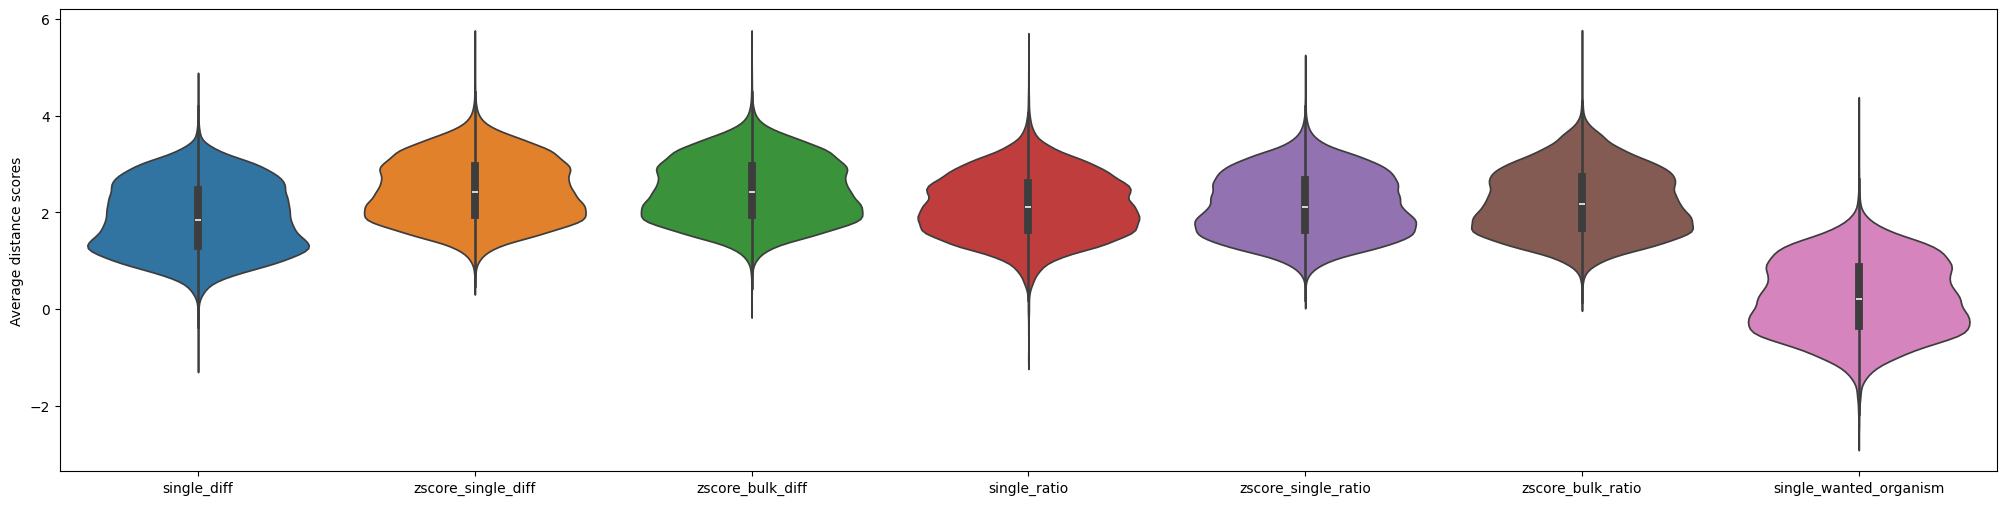

In [12]:
plt.figure(figsize=(25, 6))
ax = sns.violinplot(data=filtered_result[average_distance_score_variant_names])
ax.set_xticklabels([x.removeprefix("average_distance_score_") for x in average_distance_score_variant_names])  # Labels only
plt.ylabel("Average distance scores")
plt.show()

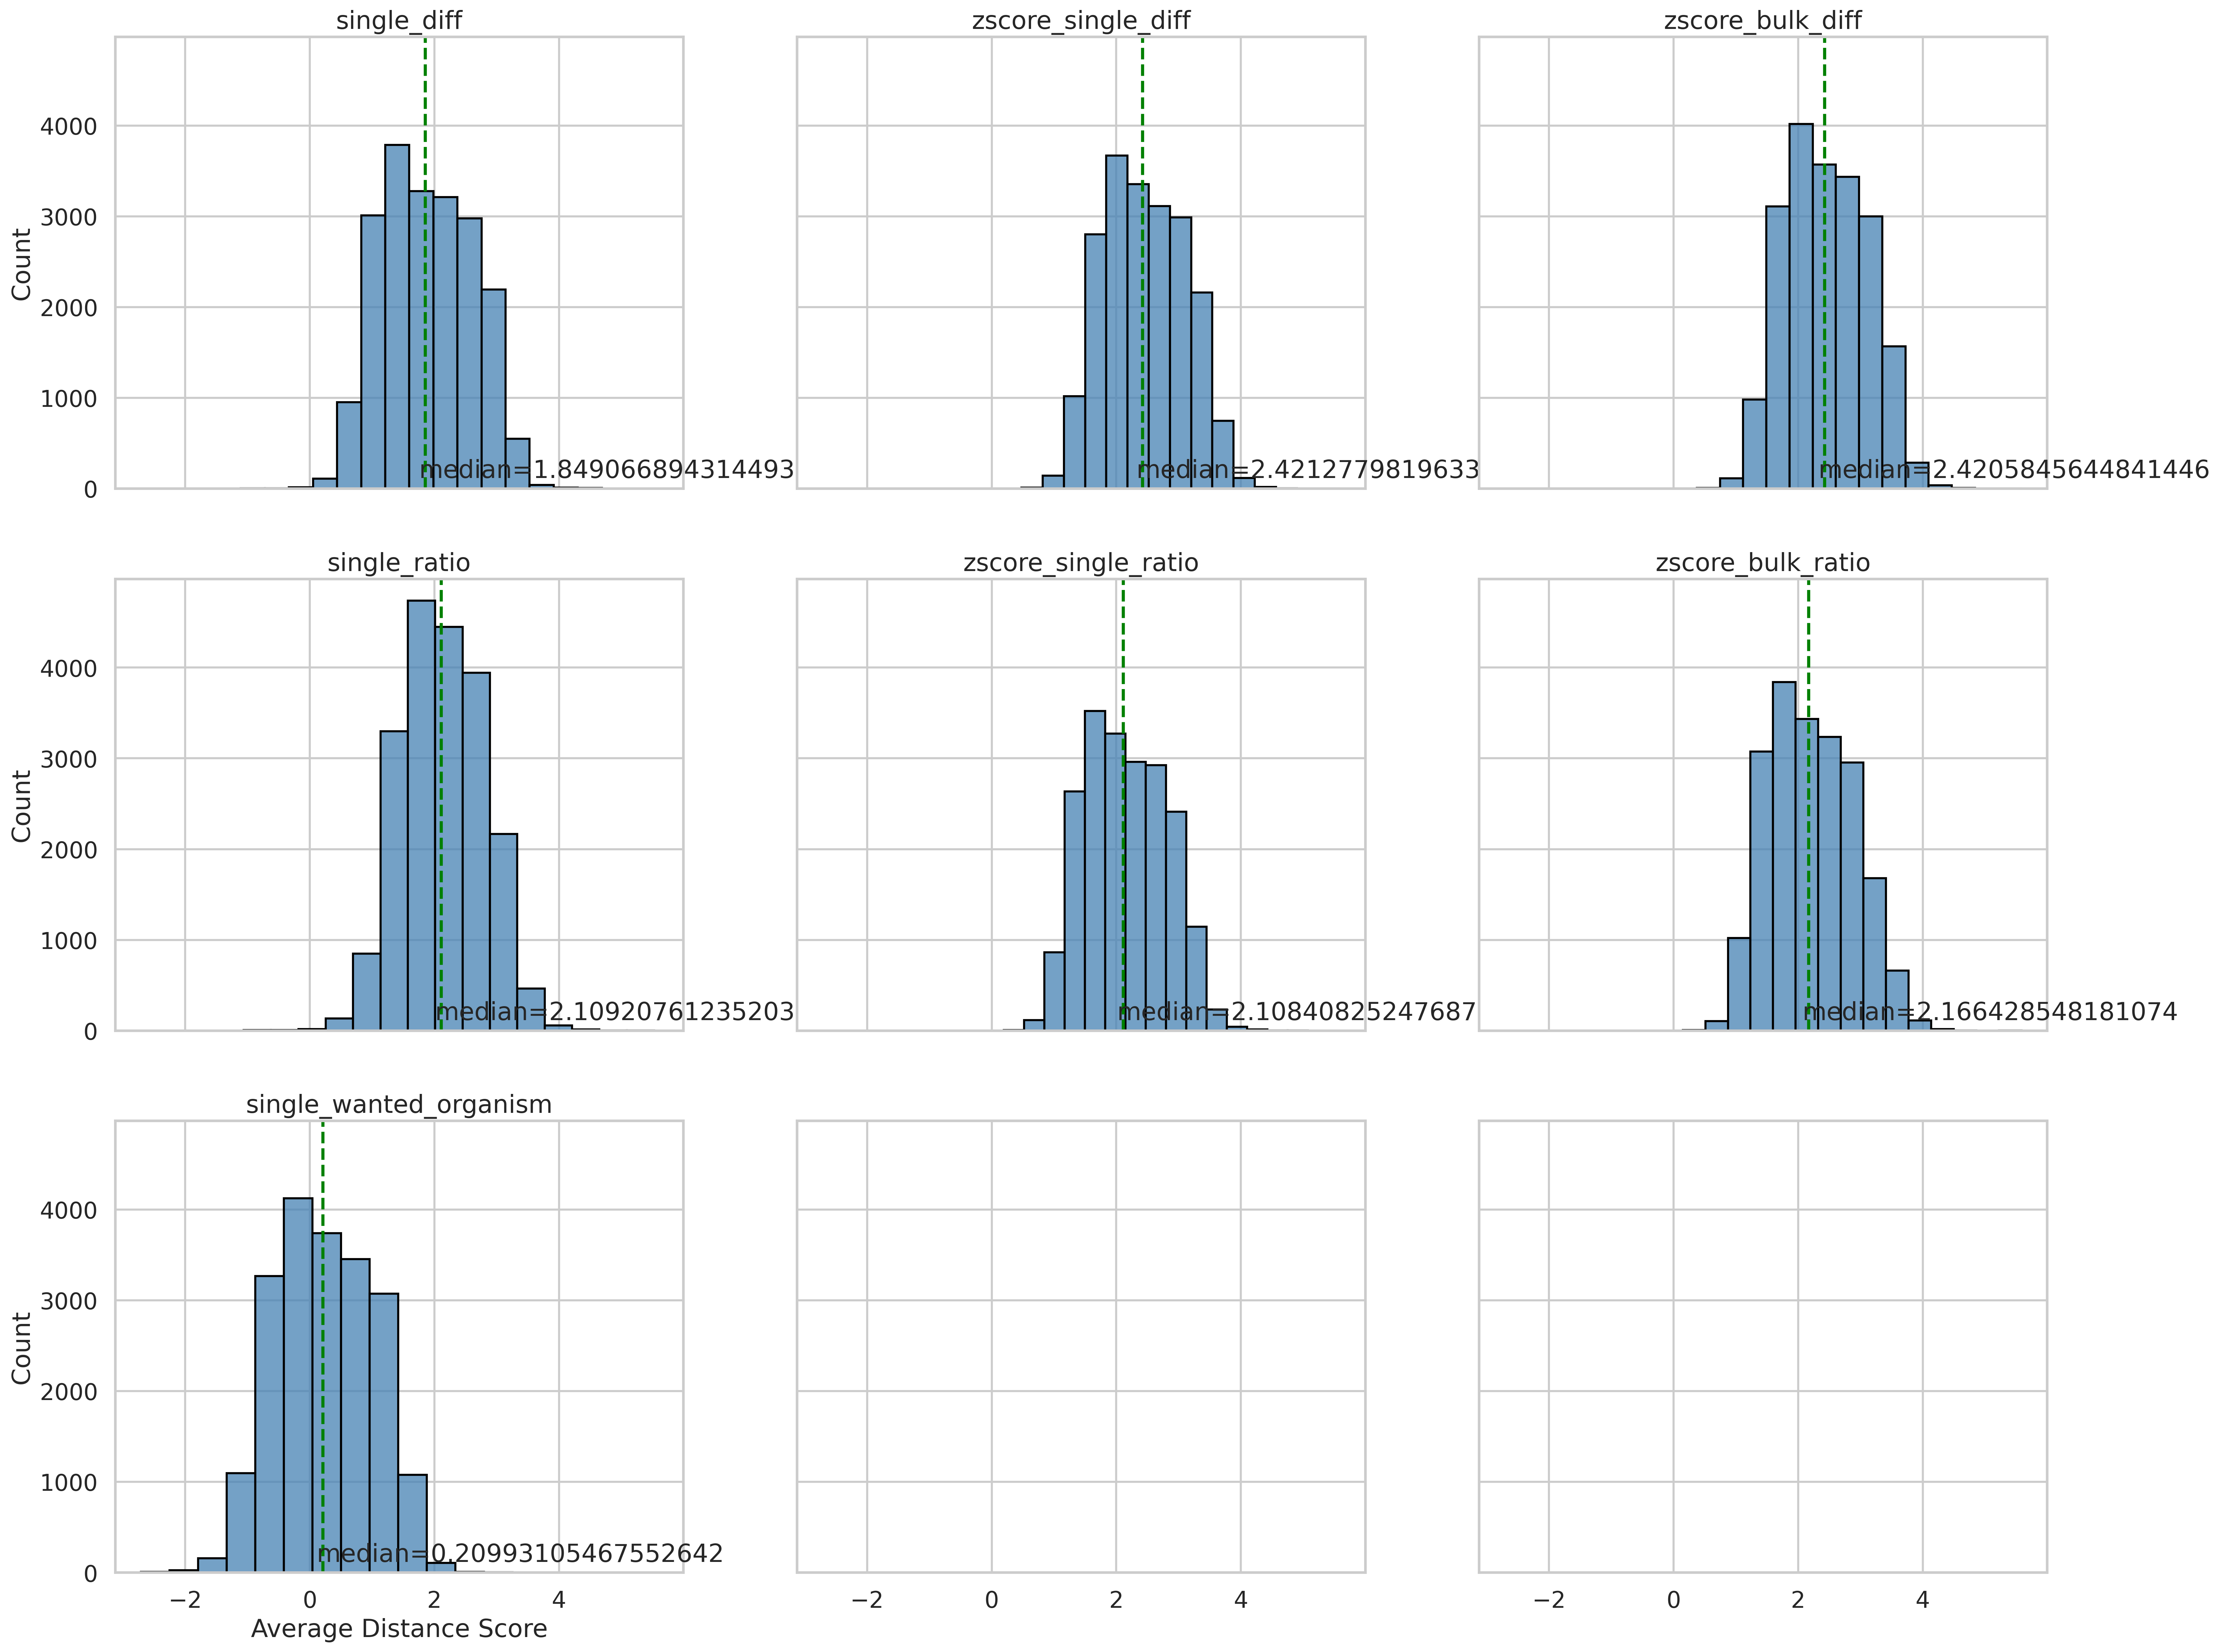

In [13]:
sns.set(style="whitegrid", context="talk")  # 'talk' or 'paper' context

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 20), dpi=300, sharex=True, sharey=True)

axes = axes.flatten()  # Flatten to 1D array for easy indexing

for idx, variant in enumerate(average_distance_score_variant_names):
    sns.histplot(filtered_result[variant], bins=15, kde=False, color='steelblue', edgecolor='black', ax=axes[idx])
    axes[idx].set_title(f"{variant.removeprefix('average_distance_score_')}")
    axes[idx].set_xlabel("Average Distance Score")
    axes[idx].set_ylabel("Count")
    median_value = filtered_result[variant].median()
    axes[idx].axvline(median_value, color="green", linestyle="dashed", label="median")
    axes[idx].text(median_value-0.1, 120, f"median={median_value}")

In [15]:
single_diff_negative = filtered_result[filtered_result["average_distance_score_single_diff"] < 0] 
single_ratio_negative = filtered_result[filtered_result["average_distance_score_single_ratio"] < 0] 

zscore_bulk_diff_negative = filtered_result[filtered_result["average_distance_score_zscore_bulk_diff"] < 0] 
zscore_bulk_ratio_negative = filtered_result[filtered_result["average_distance_score_zscore_bulk_ratio"] < 0]

zscore_single_diff_negative = filtered_result[filtered_result["average_distance_score_zscore_single_diff"] < 0] 
zscore_single_ratio_negative = filtered_result[filtered_result["average_distance_score_zscore_single_ratio"] < 0] 

print(f"{len(single_diff_negative)}, percentage:{len(single_diff_negative)/len(filtered_result) * 100}")
print(f"{len(single_ratio_negative)}, percentage:{len(single_ratio_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_bulk_diff_negative)}, percentage:{len(zscore_bulk_diff_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_bulk_ratio_negative)}, percentage:{len(zscore_bulk_ratio_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_single_diff_negative)}, percentage:{len(zscore_single_diff_negative)/len(filtered_result) * 100}")
print(f"{len(zscore_single_ratio_negative)}, percentage:{len(zscore_single_ratio_negative)/len(filtered_result) * 100}")

21, percentage:0.10423905489923557
17, percentage:0.08438399682319071
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0
0, percentage:0.0


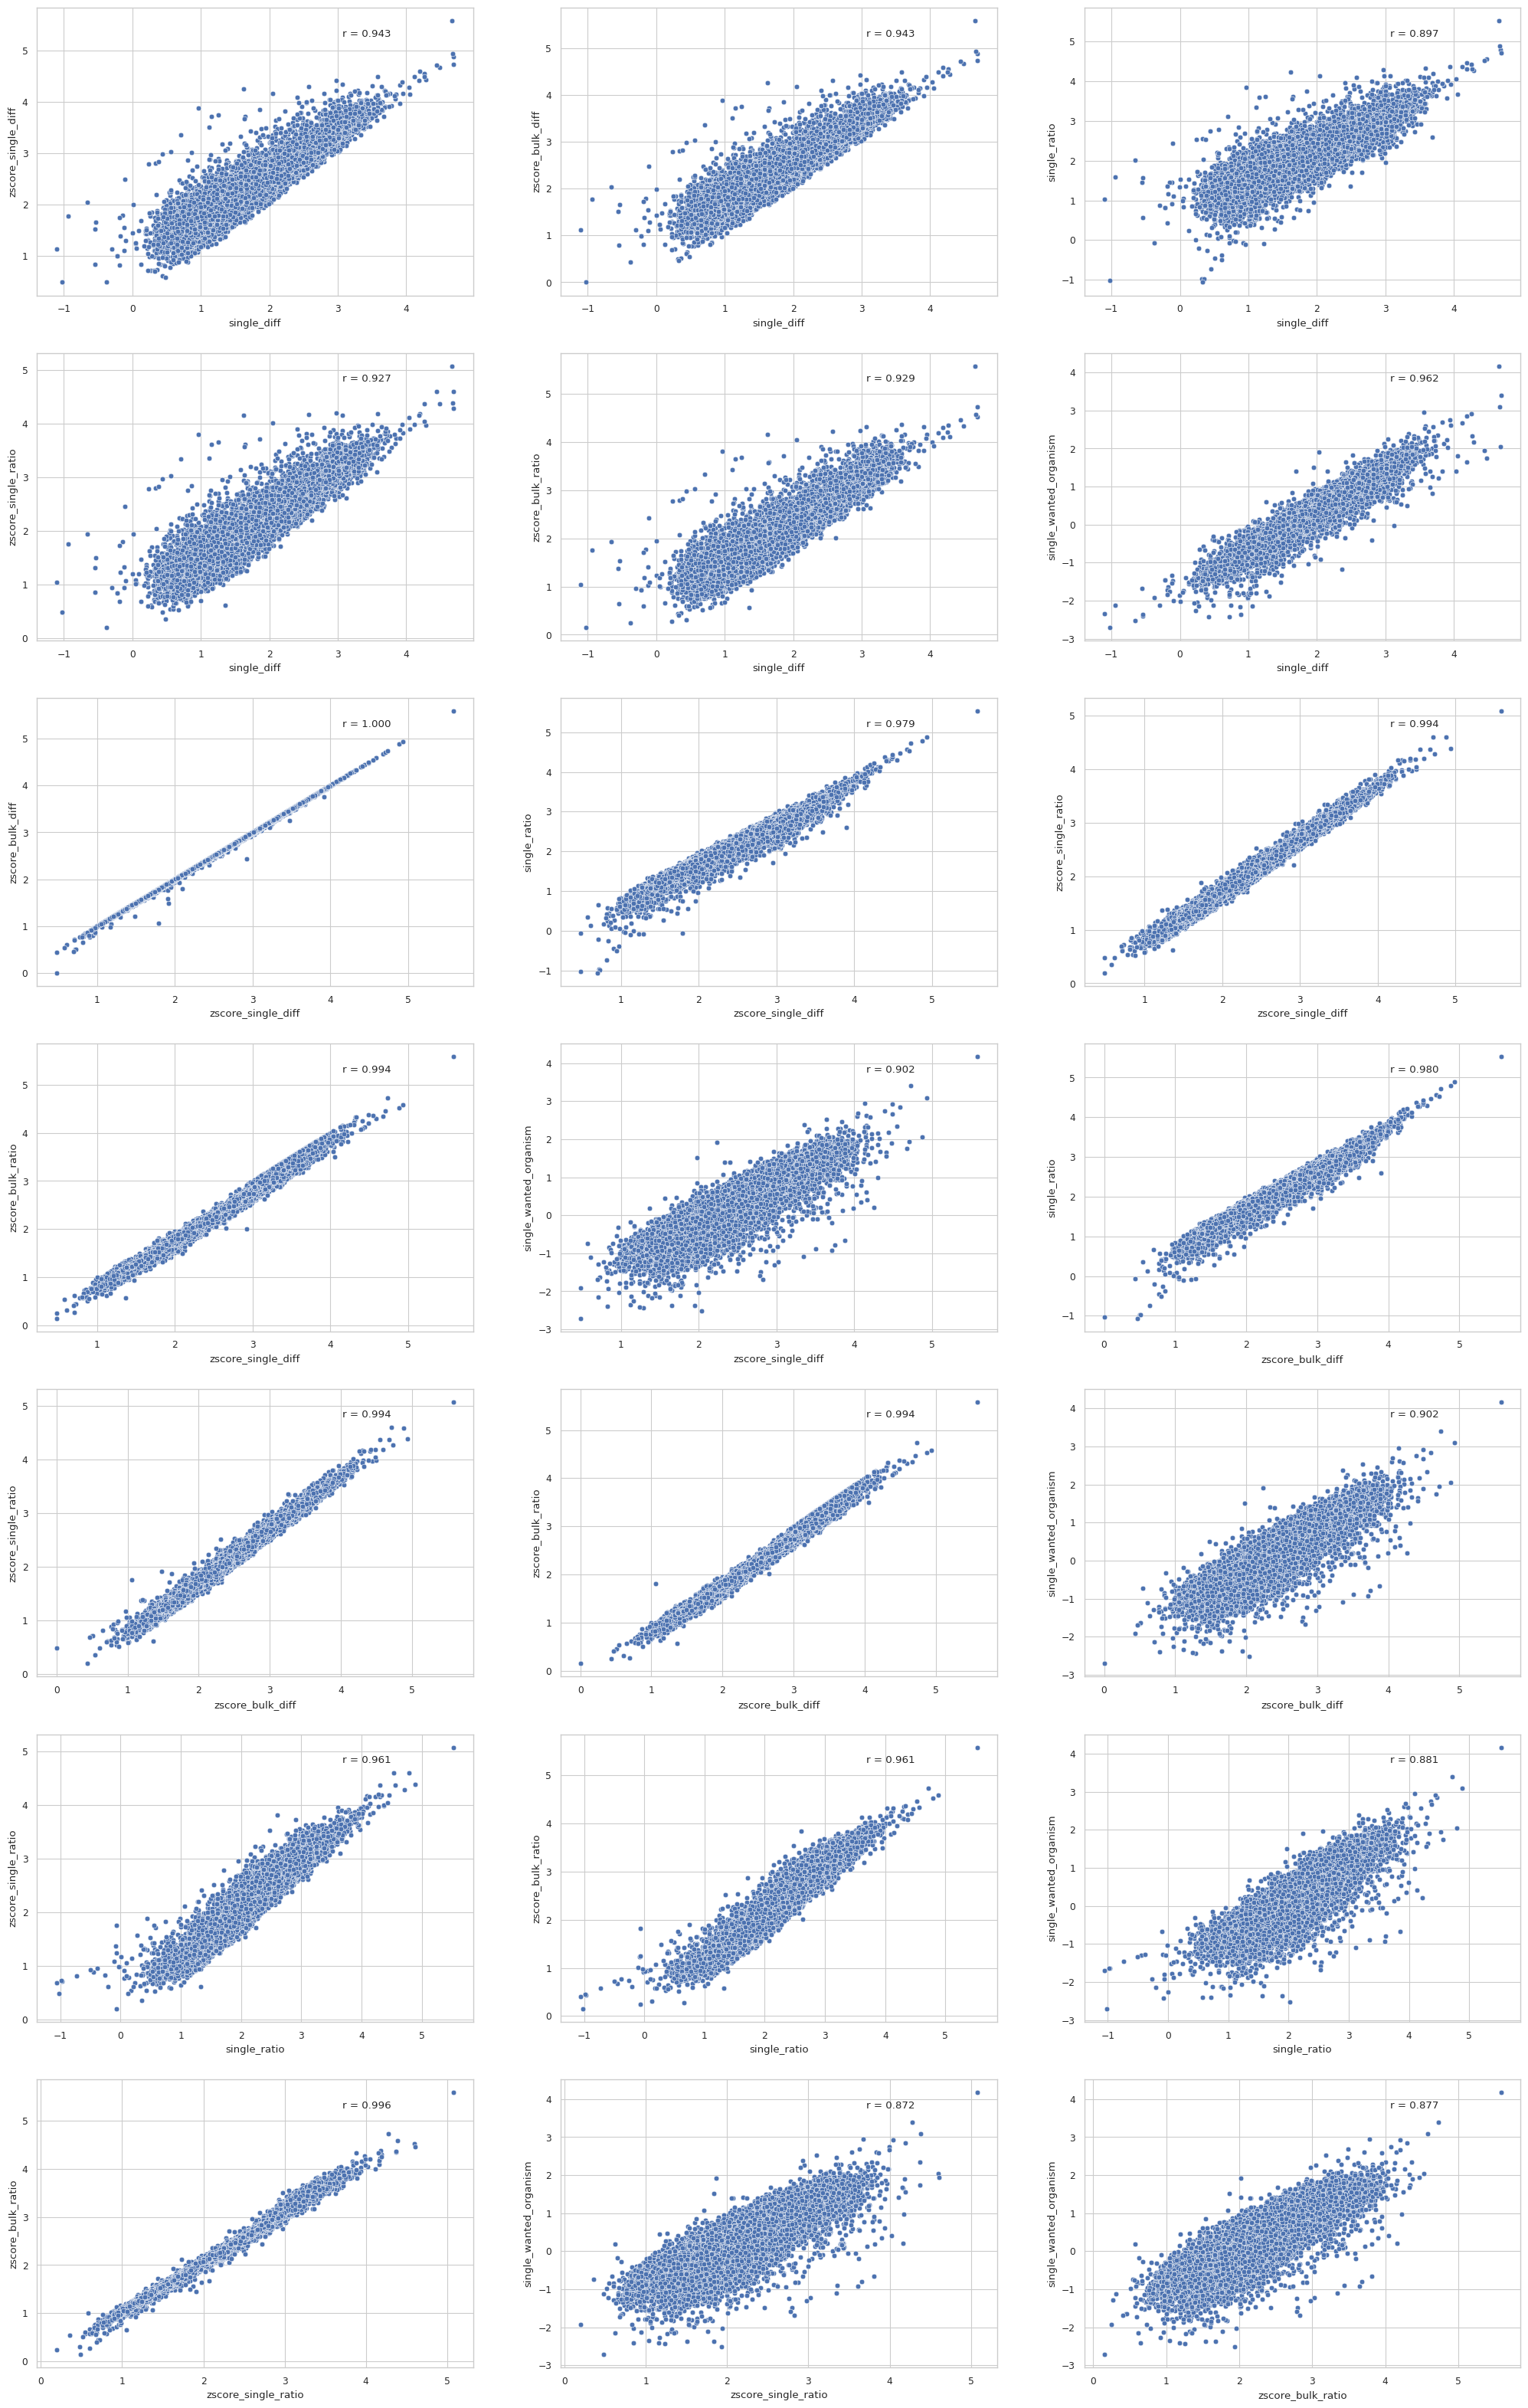

In [16]:
plot_comparative_graphs(filtered_result, "average_distance_score")

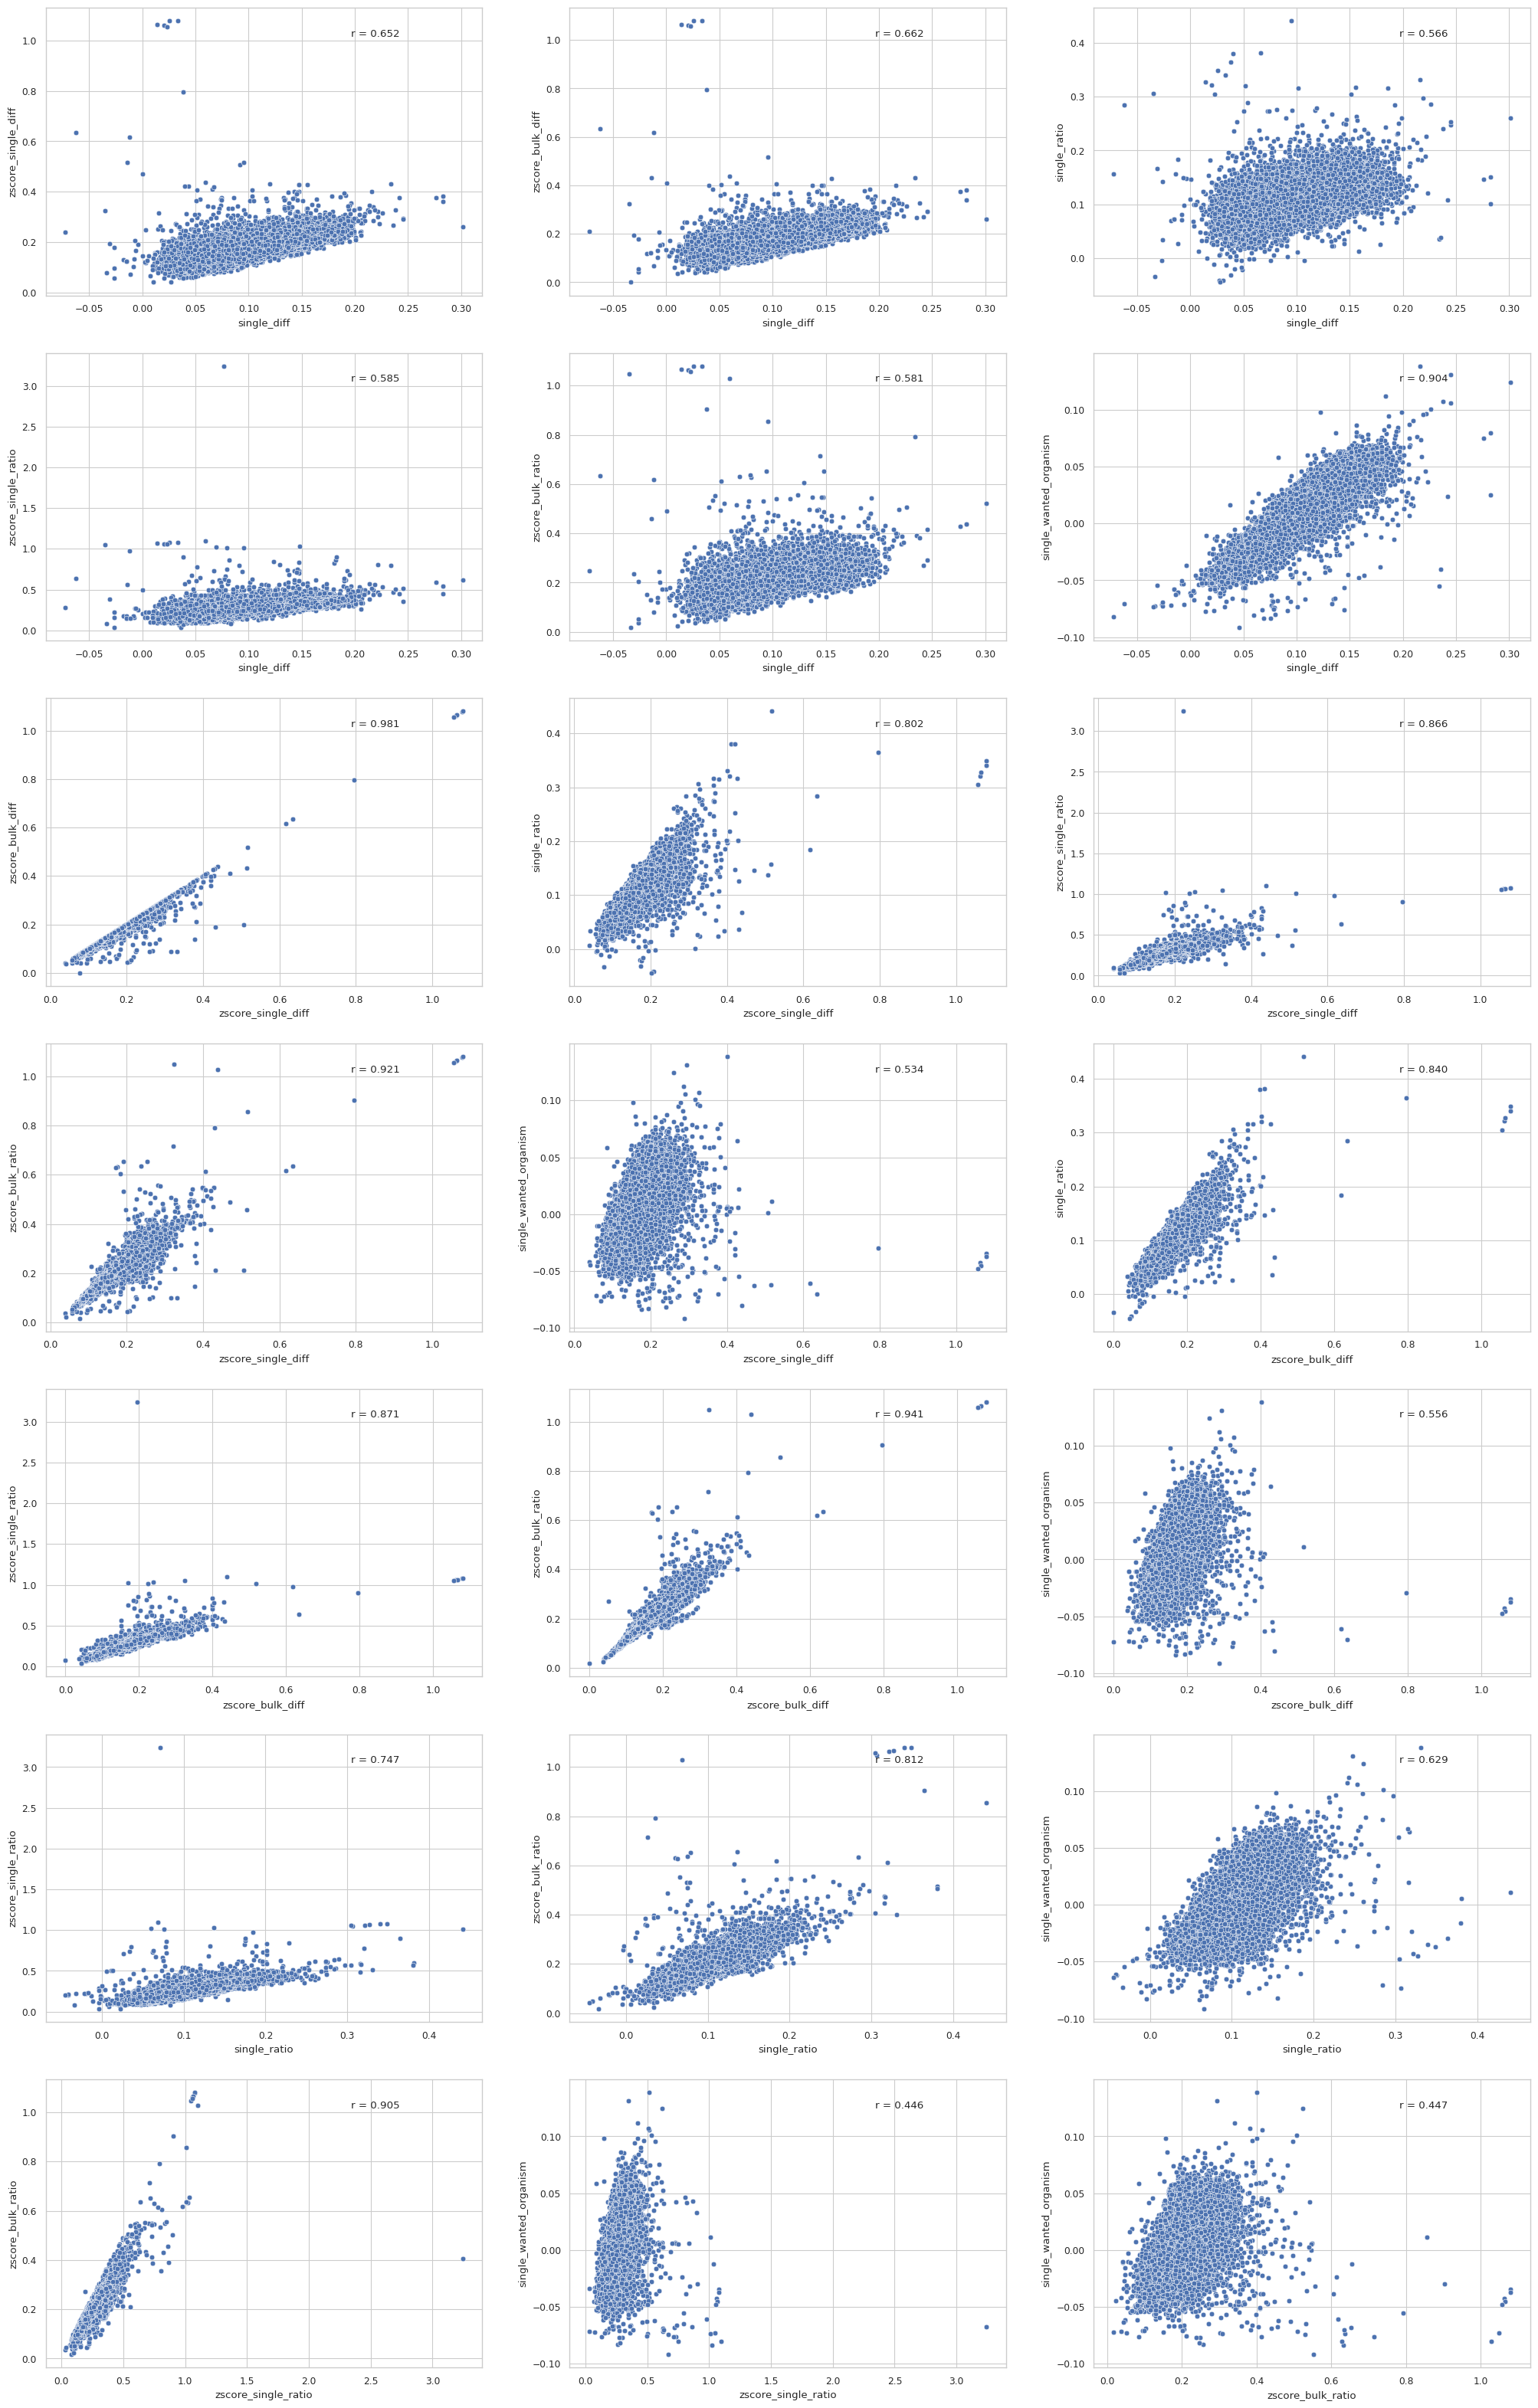

In [27]:
plot_comparative_graphs_log_ratio(filtered_result, "ratio_score")

### Performance evaluation

In [34]:
run_time_cols = ["run_time_" +variant_name for variant_name in variant_names]

run_times_df = filtered_result[run_time_cols]
run_times_df.index.name = 'run_id'
run_times_df = run_times_df.reset_index()
run_times_df["run_id"] = run_times_df["run_id"] + 1

run_times_long = pd.melt(
    run_times_df, 
    id_vars='run_id', 
    var_name='run_time', 
    value_name='runtime',
)

<Axes: xlabel='runtime', ylabel='Proportion'>

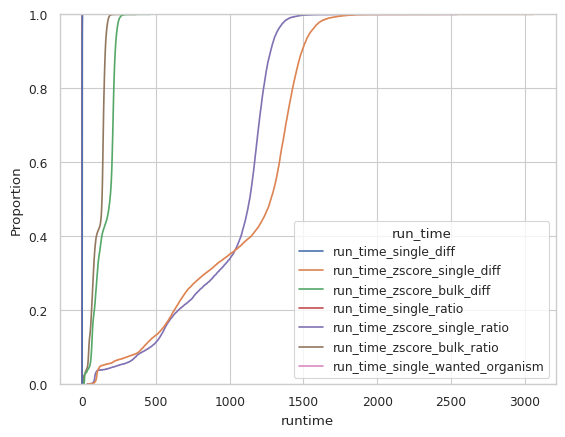

In [38]:
sns.set(style="whitegrid", context="paper")
sns.ecdfplot(data=run_times_long, x='runtime', hue='run_time')
# sns.violinplot(data=run_times_long, x='run_time', y='runtime')